# Attention Head Analysis of GPT-2

In [1]:
!pip install -U transformers datasets nnsight

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Suc

### Importing the Required libraries

In [2]:
import torch
import torch.nn as nn
from transformers import GPT2TokenizerFast, GPT2Config, GPT2ForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
from nnsight import LanguageModel, NNsight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score


### Data Preprocessing

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Load the SST-2 dataset
dataset = load_dataset('glue', 'sst2')
train_subset_size = 5000
validation_subset_size = 500

# Create subsets
train_indices = list(range(train_subset_size))
validation_indices = list(range(validation_subset_size))

# Initialize the GPT-2 tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set pad token


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [4]:
def preprocess_function(examples):
    return tokenizer(
        examples['sentence'],
        truncation=True,
        padding='max_length',
        max_length=128,
    )

# Apply preprocessing to the dataset
encoded_dataset = dataset.map(preprocess_function, batched=True)

encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create subsets using Subset
train_dataset = Subset(encoded_dataset['train'], train_indices)
validation_dataset = Subset(encoded_dataset['validation'], validation_indices)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
validation_dataloader = DataLoader(validation_dataset, batch_size=16)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [5]:
# Load GPT-2 for sequence classification
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.config.pad_token_id = model.config.eos_token_id  # Set pad token ID

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize NNsight with GPT-2
llm = NNsight(model)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Comptuing Head Importance of heads

In [6]:
def compute_head_importance(model, dataloader):
    model.eval()
    num_layers = model.config.n_layer
    num_heads = model.config.n_head
    head_importance = torch.zeros(num_layers, num_heads).to(device)
    total_tokens = 0

    # Define hook functions
    def get_attention_forward_hook(layer_idx):
        def forward_hook(module, input, output):
            attention = output[2]
            attention_outputs[layer_idx] = attention[0]
            attention_outputs[layer_idx].retain_grad()
        return forward_hook

    hooks = []
    for layer_idx, layer in enumerate(model.transformer.h):
        hook = layer.register_forward_hook(get_attention_forward_hook(layer_idx))
        hooks.append(hook)

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        model.zero_grad()
        attention_outputs = {}

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            output_attentions=True,
            return_dict=True
        )

        loss = outputs.loss

        loss.backward()

        # Accumulate gradients
        for layer_idx in range(num_layers):
            attn = attention_outputs.get(layer_idx)
            if attn is None or attn.grad is None:
                continue

            grad = attn.grad
            # Compute average absolute gradient
            grad = grad.abs().mean(dim=(0, 2, 3))  # Shape: (num_heads,)
            head_importance[layer_idx] += grad.detach()

        total_tokens += input_ids.size(0) * input_ids.size(1)

    for hook in hooks:
        hook.remove()

    head_importance /= total_tokens
    return head_importance.cpu()

head_importance = compute_head_importance(llm, train_dataloader)

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [7]:
def create_head_mask(heads_to_disable):
    head_mask = torch.ones(num_layers, num_heads)
    for layer, head in heads_to_disable:
        head_mask[layer, head] = 0
    return head_mask.to(device)

In [8]:
def evaluate_with_head_mask(model, dataloader, head_mask):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                head_mask=head_mask,
                labels=labels
            )
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

def evaluate(model, dataloader):
    return evaluate_with_head_mask(model, dataloader, head_mask=None)

In [9]:
baseline_accuracy = evaluate(model, validation_dataloader)
print(f'Baseline Validation Accuracy: {baseline_accuracy:.4f}')


Baseline Validation Accuracy: 0.4700


### Fine Tuning the Model

In [10]:
num_layers = model.config.n_layer
num_heads = model.config.n_head

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 5
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

baseline_accuracy = evaluate(model, validation_dataloader)
print(f'Baseline Validation Accuracy after fine tuning: {baseline_accuracy:.4f}')

Baseline Validation Accuracy after fine tuning: 0.8820


### Getting heads from each layer

In [11]:
def get_top_bottom_random_heads(head_importance, K):
    importance = head_importance.view(-1)
    sorted_indices = torch.argsort(importance, descending=True)

    topk_indices = sorted_indices[:K * num_layers]
    bottomk_indices = sorted_indices[-K * num_layers:]

    topk_heads = [(int(idx // num_heads), int(idx % num_heads)) for idx in topk_indices]
    bottomk_heads = [(int(idx // num_heads), int(idx % num_heads)) for idx in bottomk_indices]

    # For random heads
    random_heads = []
    for layer in range(num_layers):
        random_indices = random.sample(range(num_heads), K)
        random_heads.extend([(layer, head) for head in random_indices])

    return topk_heads, bottomk_heads, random_heads

In [12]:
def get_new_model_from_state_dict(state_dict):
    model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
    model.config.pad_token_id = model.config.eos_token_id
    model.load_state_dict(state_dict, strict=True)
    model.to(device)
    return model

def finetune_with_head_mask(original_model, train_dataloader, head_mask, device, epochs=5):
    # Save original state dict
    state_dict = original_model.state_dict()

    # Initialize a fresh model and load state_dict
    temp_model = get_new_model_from_state_dict(state_dict)
    optimizer = torch.optim.AdamW(temp_model.parameters(), lr=5e-5)

    temp_model.train()
    for epoch in range(epochs):
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = temp_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                head_mask=head_mask
            )
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return temp_model

### Results of removing heads from each layer

In [13]:
results = {}
results['baseline'] = baseline_accuracy

for K in [2,4]:
    topk_heads, bottomk_heads, random_heads = get_top_bottom_random_heads(head_importance, K)

    head_mask_topk = create_head_mask(topk_heads)
    head_mask_bottomk = create_head_mask(bottomk_heads)
    head_mask_random = create_head_mask(random_heads)

    # Fine-tune after disabling heads
    finetuned_topk_model = finetune_with_head_mask(model, train_dataloader, head_mask_topk, device)
    accuracy_finetuned_topk = evaluate_with_head_mask(finetuned_topk_model, validation_dataloader, head_mask_topk)

    finetuned_bottomk_model = finetune_with_head_mask(model, train_dataloader, head_mask_bottomk, device)
    accuracy_finetuned_bottomk = evaluate_with_head_mask(finetuned_bottomk_model, validation_dataloader, head_mask_bottomk)

    finetuned_random_model = finetune_with_head_mask(model, train_dataloader, head_mask_random, device)
    accuracy_finetuned_random = evaluate_with_head_mask(finetuned_random_model, validation_dataloader, head_mask_random)

    results[(K, 'topk_finetuned')] = accuracy_finetuned_topk
    results[(K, 'bottomk_finetuned')] = accuracy_finetuned_bottomk
    results[(K, 'random_finetuned')] = accuracy_finetuned_random

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

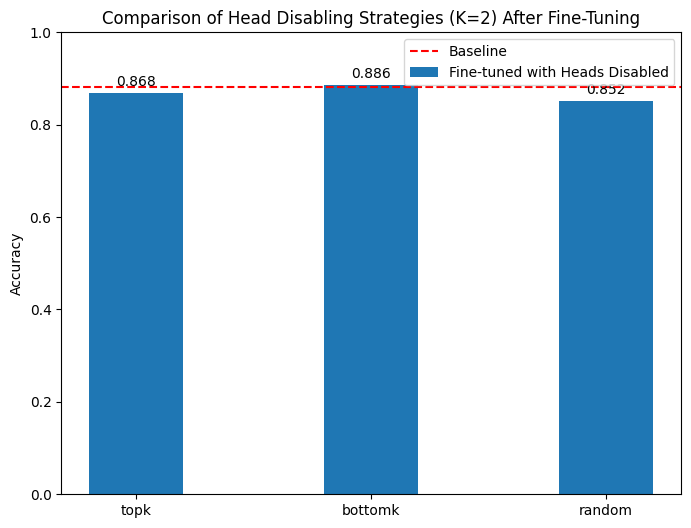

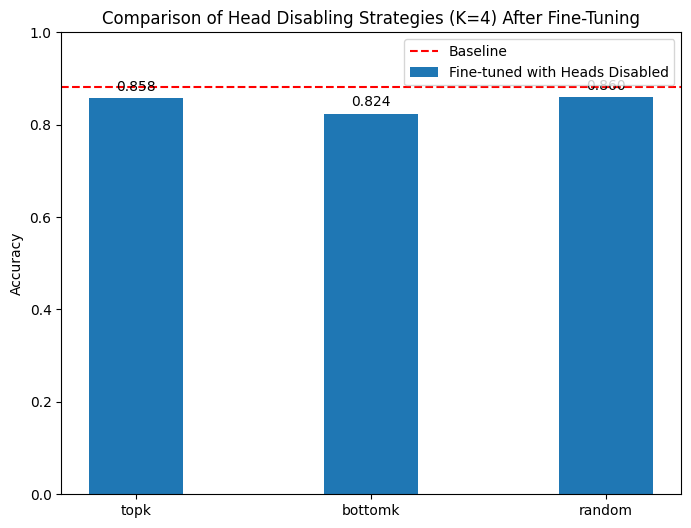

In [14]:
for K in [2,4]:
    conditions = ['topk', 'bottomk', 'random']
    finetuned_acc = [results[(K, c + '_finetuned')] for c in conditions]

    x = np.arange(len(conditions))  # positions for groups
    width = 0.4

    fig, ax = plt.subplots(figsize=(8, 6))
    rects = ax.bar(x, finetuned_acc, width, label='Fine-tuned with Heads Disabled')

    ax.set_ylabel('Accuracy')
    ax.set_title(f'Comparison of Head Disabling Strategies (K={K}) After Fine-Tuning')
    ax.set_xticks(x)
    ax.set_xticklabels(conditions)
    ax.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects)

    plt.ylim(0.0, 1.0)
    plt.show()

## Single Headed Attention

In [15]:
class SingleHeadSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.num_heads = 1  # Single head
        self.head_dim = self.embed_dim // self.num_heads

        self.c_attn = nn.Linear(self.embed_dim, self.embed_dim * 3)
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

        self.register_buffer("mask", torch.tril(torch.ones(config.n_positions, config.n_positions))
                             .view(1, 1, config.n_positions, config.n_positions))

    def forward(self, x, layer_past=None, attention_mask=None, head_mask=None, use_cache=False, output_attentions=False):
        query, key, value = self.c_attn(x).split(self.embed_dim, dim=2)

        query = query.view(x.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(x.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(x.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        attn_weights = torch.matmul(query, key.transpose(-2, -1))
        attn_weights = attn_weights / (float(self.head_dim) ** 0.5)

        # Apply causal mask
        attn_weights = attn_weights.masked_fill(self.mask[:, :, :attn_weights.size(-2), :attn_weights.size(-1)] == 0, float('-inf'))

        # Apply attention mask
        if attention_mask is not None:
            attn_weights = attn_weights + attention_mask

        attn_weights = torch.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        if head_mask is not None:
            attn_weights = attn_weights * head_mask

        attn_output = torch.matmul(attn_weights, value)
        attn_output = attn_output.transpose(1, 2).contiguous().view(x.size(0), -1, self.embed_dim)
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)

        outputs = (attn_output,)
        if output_attentions:
            outputs += (attn_weights,)

        if use_cache:
            outputs += (attn_output, ((),))

        return outputs


In [16]:
for layer in model.transformer.h:
    layer.attn = SingleHeadSelfAttention(model.config).to(device)

### Results of the single head model

In [17]:
epoch_values = range(1, 6)
single_head_accuracies = []

for e in epoch_values:
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    epochs = 5

    for epoch in range(epochs):
        model.train()
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    acc = evaluate(model, validation_dataloader)
    single_head_accuracies.append(acc)
    print(f"Single-Headed Model: Epochs={e}, Accuracy={acc:.4f}")

Single-Headed Model: Epochs=1, Accuracy=0.7980
Single-Headed Model: Epochs=2, Accuracy=0.7760
Single-Headed Model: Epochs=3, Accuracy=0.7700
Single-Headed Model: Epochs=4, Accuracy=0.7700
Single-Headed Model: Epochs=5, Accuracy=0.7760


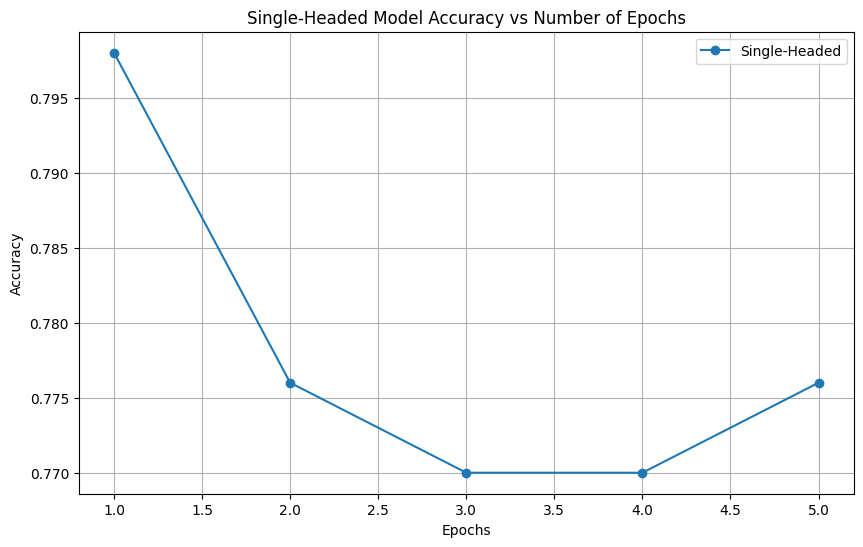

In [18]:
# Plot accuracy vs epochs for the single-headed model
plt.figure(figsize=(10,6))
plt.plot(epoch_values, single_head_accuracies, marker='o', label='Single-Headed')
plt.title('Single-Headed Model Accuracy vs Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()